In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt


In [2]:
# Fetch historical NASDAQ Composite Index data
nasdaq = yf.download('^IXIC', start='2010-01-01', end='2023-10-01')

[*********************100%***********************]  1 of 1 completed


Dataset Overview:

Shape of the dataset: (3440, 20)

First few rows:
Price                        Adj Close        Close         High          Low  \
Ticker                           ^IXIC        ^IXIC        ^IXIC        ^IXIC   
Date                                                                            
2010-02-01 00:00:00+00:00  2171.199951  2171.199951  2171.199951  2152.260010   
2010-02-02 00:00:00+00:00  2190.060059  2190.060059  2193.659912  2161.469971   
2010-02-03 00:00:00+00:00  2190.909912  2190.909912  2194.530029  2176.750000   
2010-02-04 00:00:00+00:00  2125.429932  2125.429932  2178.250000  2125.429932   
2010-02-05 00:00:00+00:00  2141.120117  2141.120117  2142.270020  2100.169922   

Price                             Open      Volume    Return        SMA_5  \
Ticker                           ^IXIC       ^IXIC                          
Date                                                                        
2010-02-01 00:00:00+00:00  2155.810059  2234140000 

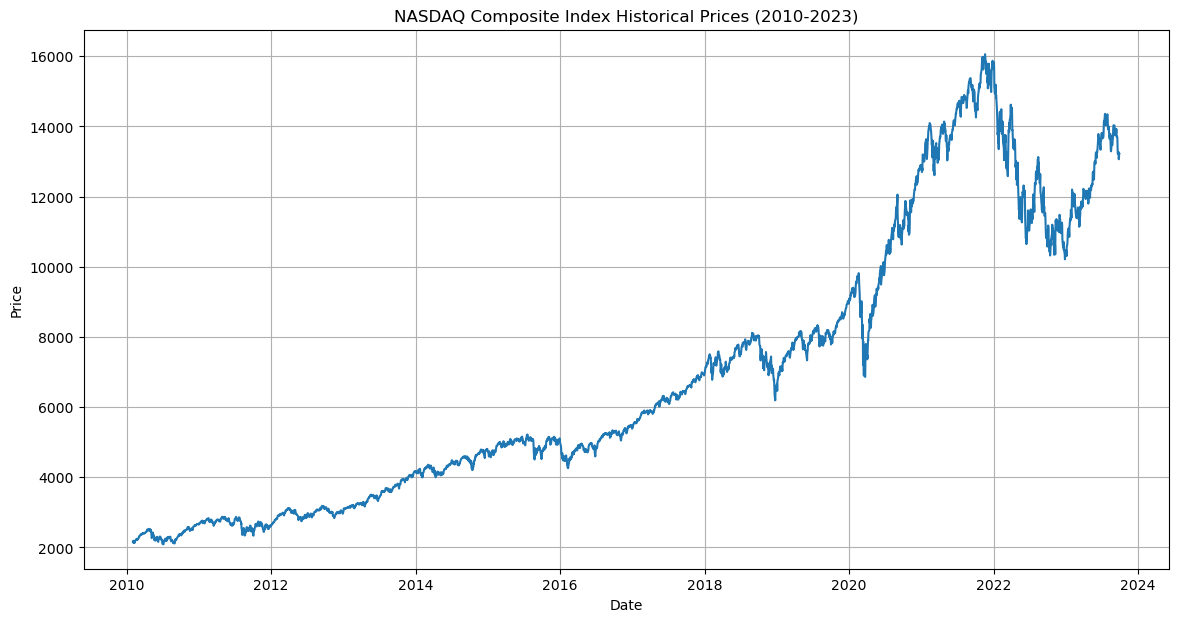

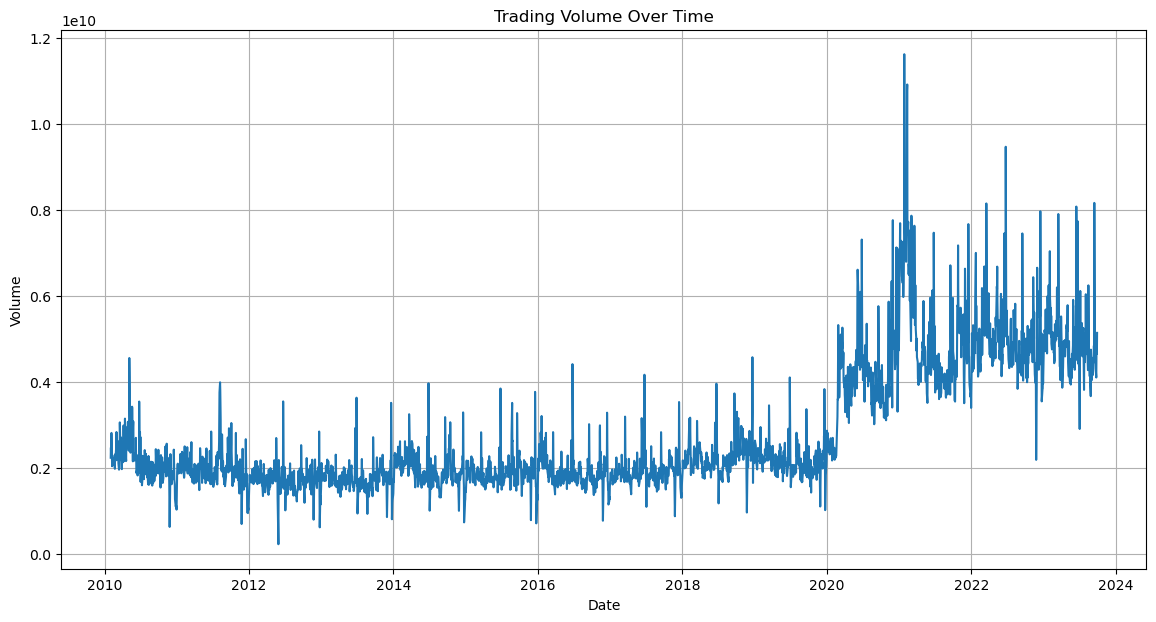


Correlation Matrix:
Price              Open      High       Low     Close    Volume
Ticker            ^IXIC     ^IXIC     ^IXIC     ^IXIC     ^IXIC
Price  Ticker                                                  
Open   ^IXIC   1.000000  0.999907  0.999865  0.999741  0.815677
High   ^IXIC   0.999907  1.000000  0.999827  0.999861  0.817733
Low    ^IXIC   0.999865  0.999827  1.000000  0.999881  0.812834
Close  ^IXIC   0.999741  0.999861  0.999881  1.000000  0.815176
Volume ^IXIC   0.815677  0.817733  0.812834  0.815176  1.000000


In [16]:
# Exploratory Data Analysis
print("Dataset Overview:")
print("\nShape of the dataset:", nasdaq.shape)
print("\nFirst few rows:")
print(nasdaq.head())

print("\nBasic statistics:")
print(nasdaq.describe())

print("\nChecking for missing values:")
print(nasdaq.isnull().sum())

# Plotting historical NASDAQ prices
plt.figure(figsize=(14, 7))
plt.plot(nasdaq.index, nasdaq['Close'])
plt.title('NASDAQ Composite Index Historical Prices (2010-2023)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Volume analysis
plt.figure(figsize=(14, 7))
plt.plot(nasdaq.index, nasdaq['Volume'])
plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True)
plt.show()

# Correlation matrix of price data
correlation_matrix = nasdaq[['Open', 'High', 'Low', 'Close', 'Volume']].corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)


In [3]:
# Feature Engineering: Create Technical Indicators
def create_features(df):
    df['Return'] = df['Close'].pct_change()
    df['SMA_5'] = df['Close'].rolling(window=5).mean()
    df['SMA_10'] = df['Close'].rolling(window=10).mean()
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
    df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['Momentum_10'] = df['Close'] - df['Close'].shift(10)
    df['Volatility_10'] = df['Return'].rolling(window=10).std()
    df['RSI_14'] = compute_RSI(df['Close'], 14)
    df.dropna(inplace=True)
    return df

# Relative Strength Index (RSI) Calculation
def compute_RSI(series, period):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [4]:
nasdaq = create_features(nasdaq)

# Define Features and Target Variable
features = ['SMA_5', 'SMA_10', 'SMA_20', 'EMA_10', 'EMA_20', 'Momentum_10', 'Volatility_10', 'RSI_14']
X = nasdaq[features]
y = np.where(nasdaq['Close'].shift(-1) > nasdaq['Close'], 1, -1)  # Next day's price movement

In [5]:
# Split Data Using TimeSeriesSplit to Preserve Temporal Order
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [6]:
# Train the Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [7]:
# Make Predictions
nasdaq['Predicted_Signal'] = model.predict(X)
nasdaq['Predicted_Signal'] = np.where(nasdaq['Predicted_Signal'] > 0, 1, -1)

In [8]:
# Implement Trading Strategy
nasdaq['Strategy_Return'] = nasdaq['Return'] * nasdaq['Predicted_Signal'].shift(1)
nasdaq['Cumulative_Strategy_Return'] = (1 + nasdaq['Strategy_Return']).cumprod()
nasdaq['Cumulative_Market_Return'] = (1 + nasdaq['Return']).cumprod()

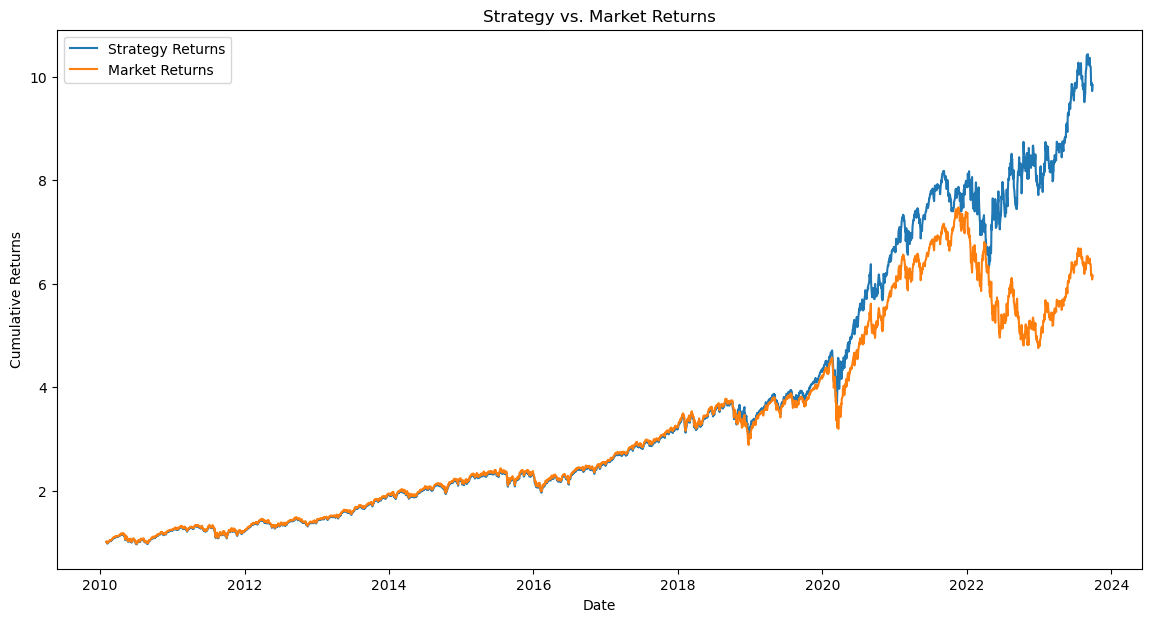

In [9]:
# Backtesting: Plot Cumulative Returns
plt.figure(figsize=(14,7))
plt.plot(nasdaq.index, nasdaq['Cumulative_Strategy_Return'], label='Strategy Returns')
plt.plot(nasdaq.index, nasdaq['Cumulative_Market_Return'], label='Market Returns')
plt.title('Strategy vs. Market Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

In [10]:
# Performance Metrics
def performance_metrics(df):
    total_return = df['Cumulative_Strategy_Return'][-1] - 1
    annual_return = df['Strategy_Return'].mean() * 252
    annual_volatility = df['Strategy_Return'].std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_volatility
    max_drawdown = (df['Cumulative_Strategy_Return'].cummax() - df['Cumulative_Strategy_Return']).max()
    return total_return, annual_return, annual_volatility, sharpe_ratio, max_drawdown

total_return, annual_return, annual_volatility, sharpe_ratio, max_drawdown = performance_metrics(nasdaq)

C:\Users\mkans\AppData\Local\Temp\ipykernel_18444\1304310770.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_return = df['Cumulative_Strategy_Return'][-1] - 1


In [11]:
print(f"Total Return: {total_return:.2%}")
print(f"Annual Return: {annual_return:.2%}")
print(f"Annual Volatility: {annual_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")


Total Return: 884.26%
Annual Return: 18.86%
Annual Volatility: 20.47%
Sharpe Ratio: 0.92
Max Drawdown: 186.77%
